# Monte Carlo Simulation of a Particle Physics Experiment

* **Author:** June Vanlerberghe

* **Date:** November 12, 2020

* **Time spent on this assignment:**

In [ ]:
#** COLAB/HOME users: run this cell!*****
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/particle_helper.py

--2020-11-19 21:27:25--  https://courses.physics.illinois.edu/phys246/fa2020/code/particle_helper.py
Resolving courses.physics.illinois.edu (courses.physics.illinois.edu)... 130.126.151.14
Connecting to courses.physics.illinois.edu (courses.physics.illinois.edu)|130.126.151.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9503 (9.3K) [application/octet-stream]
Saving to: ‘particle_helper.py.3’

particle_helper.py. 100%[===================>]   9.28K  --.-KB/s    in 0s      

2020-11-19 21:27:26 (151 MB/s) - ‘particle_helper.py.3’ saved [9503/9503]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from particle_helper import Kdecay
def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','Axes3D','Kdecay']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    return
import datetime;datetime.datetime.now()

datetime.datetime(2020, 11, 19, 21, 27, 30, 945537)

## Background

### Some particle physics history
In 1979 a particle physics experiment led by Jim Christenson published a report[<sup>1</sup>](#fn1)  describing a small anomaly in the behavior of K mesons that suggested a breakdown in causality at subnuclear distance scales. The effect—seen at two standard deviations above background—deserved further investigation. Surely it must have been a matter of bad luck, or unforeseen systematic errors. But confirmation of Christenson’s result would show that the laws of nature were, at small distances, non-local (a string theory, perhaps), or else that physical law could no longer be formulated in mathematical language. Our world would be properly described by string theory, or by magic.  


Some years after the Christenson result George Gollin proposed a new experiment using a different technique to look for the same effect. We planned to do it at Fermilab, with much better precision and greatly reduced systematic uncertainties, and a few of us set about designing the apparatus for the measurement[<sup>2</sup>](#fn2).   


We planned to study the decay rates of neutral K mesons into neutral and charged pions:
$$
K \rightarrow \pi^0\pi^0;\quad K\rightarrow\pi^+\pi^-
$$
in a pair of specially prepared beams. The apparatus would measure the momenta of charged pions using a spectrometer comprising four tracking chambers and a large dipole magnet. We of course needed a hole near the center through which a beam of kaons that hadn’t decayed in flight would pass, rather than smacking into the apparatus.  

![image.png](https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/detector.png)

<div style="text-align:center">Schematic of the proposed experiment</div>

We would identify $K$ mesons in our data by seeing that the "invariant mass" $(E^2/c^2 - p^2)^{1/2}$ of the parent particle that had yielded the pions was consistent with the kaon mass of 498 MeV/$c^2$. Because of the manner in which we had prepared the kaon beams before they arrived at the experiment, we would extract physics from our data by measuring the double ratio
$$
R \equiv \frac{\Gamma_{beam1}(K\rightarrow\pi^0\pi^0)}{\Gamma_{beam2}(K\rightarrow\pi^0\pi^0)} {\Large /} \frac{\Gamma_{beam1}(K\rightarrow\pi^+\pi^-)}{\Gamma_{beam2}(K\rightarrow\pi^+\pi^-)}
$$

Here $\Gamma$ means "decay rate," and the ratios of those decay rates would correspond closely to the ratios of the total number of $K$ meson decays in our data. If Christenson's result had been correct, we would measure $R$ to be about 0.88, with an expected precision of $\pm$0.01. If there were no subnuclear violation of causality we would obtain 1.00.
We would reconfigure a large device we had used in a previous kaon experiment, so we needed to work within constraints that would allow us to reuse existing instrumentation as much as possible.   

We needed to maximize the device's "geometrical acceptance" in order to maximize the number of decaying kaons that would put both charged pions (or all four photons) into the tracking chambers and lead glass array. We would lose kaons that decayed too close to the tracking system because pions or photons would go down the holes in the middle of the lead glass. Kaons that decayed too far upstream would send decay products wide of the tracking chambers. So the first question to be answered was how much space to leave between the source of kaons (downstream of which kaons decayed exponentially) and the tracking system. (We would be recording data from one kaon decay at a time, with an average rate of about one per minute.)  

We used a Monte Carlo simulation of the detector and beam to address this question. After some preliminaries, we're going to begin to set this up; you’ll actually answer the question of optimum target location in this unit.

### Monte Carlo simulations in the context of designing an experiment
Let’s imagine a stripped-down Fermilab experiment to begin with a target, out of which will stream a monoenergetic "pencil" beam of relativistic $K$ mesons. By this I mean that all kaons travel in exactly the same direction with the same energy, and move precisely along the z axis. Some distance downstream of the target will be a pair of tracking chambers and a hadron calorimeter—a device that measures the energies of charged pions—but nothing else. We’ll put a hole down the center of the calorimeter to prevent the beam from damaging the device. Since a high energy neutral $K$ beam can be expected to contain more neutrons than kaons, this is an important feature of our calorimeter, which would otherwise be fried by the beam. In our model we’ll assume that kaons have total energy 60 GeV, typical of kaons in Gollin's experiment. We’ll concentrate on the charged ($\pi^+\pi^-$) decay mode.   
Here are a couple of diagrams:

![image.png](https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/beam.png)

![image.png](https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/beam_path.png)

How far from the calorimeter should we place the target that produces the kaons? Too close and one or both pions will usually go down the hole so we will not be able to measure their energies. Too far and pions will tend to go wide of the calorimeter. We want to determine the target position that maximizes the probability that a decaying kaon sends both of its pions into the active regions of the tracking chambers and calorimeter.  


Since I’ve declared that all kaons will have the same energy and travel in the same direction as they leave the target, there are only three more parameters needed to uniquely specify the kinematic properties of the final state. They are the distance from the target to the kaon decay point (as measured in the lab frame) and the $\theta$ and $\phi$ angles that one of the pions (say the $\pi^+$) makes with respect to the $z^\prime$ axis in the kaon rest frame. (Other choices of parameters are possible, but these are especially convenient.) Once we know those three parameters we are able to calculate everything there is to know about the final state pions in the lab frame. In particular, once we know $z$, $\theta^\prime$, and $\phi^\prime$  we are able to determine whether or not both pions will end up hitting the tracking chambers and calorimeter. In particle physics language, once we know $z$, $\theta^\prime$, and $\phi^\prime$ we are able to determine unambiguously whether or not that particular kaon decay "is in the acceptance of our apparatus."  

Here are figures to clarify what we mean by $z^\prime$, $\theta^\prime$, and $\phi^\prime$. The angles are the usual (physics convention) spherical coordinate angles, with the lab frame coordinate axes parallel to the $K$ rest frame axes. The angle $\phi^\prime$ is between the $x^\prime$ axis and the projection onto the $x^\prime y^\prime$ plane of the vector momentum of the positive pion. The $z^\prime$ axis (in the kaon’s rest frame) is parallel to the lab frame’s $z$ axis.


![image.png](https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/restframe1.png)

![image.png](https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/restframe2.png)

I can represent a kaon decay as occupying a point in a three dimensional parameter space (we call it a phase space) whose axes represent the decay’s particular $z$, $\theta^\prime$ and $\phi^\prime$ values. The following figure shows a schematic representation of a few dozen kaon decays that took place in our hypothetical experiment’s beamline. Some were accepted, and some were not.

![image.png](https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/phase_space.png)

By generating a large number of simulated decays with a Monte Carlo program we can calculate (and maximize) the volume inside the boundary containing accepted events. That sounds more sophisticated than it really is: we move things around (for example the distance from the target to the tracking chambers) and we watch how the fraction of the decays we are able to accept changes. The greater the phase space volume, the larger the fraction of decaying kaons that will end up in our data for later offline analysis. So we use the Monte Carlo in a way that is essentially the same as what you did to estimate the value of $\pi$.

## Exercise 1 - Minimal Simulation of the tracking chamber & Calorimeter

* **List of collaborators:** Mit, Tathagata

* **References you used in developing your code:** None

### 0. Some Preliminaries
Here are the apparatus diagrams from above:

![image.png](https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/beam.png)

![image.png](https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/beam_path.png)

There are four elements in the apparatus for us to describe in our code: the kaon production target, the first and second tracking chambers, and the hadron calorimeter. We will model the chambers and calorimeter as infinitesimally thin in the z direction and square in cross section, centered on the z axis, along which the kaon beam travels. The calorimeter has a square hole in its center through which debris from the target, and particles in the beam that have not yet decayed, will pass.  

The two tracking chambers are separated by 10 meters along the beam direction; the calorimeter is 5 meters downstream of the second tracker. For technical reasons (umm… actually just to simplify things for you) the separation between chambers, and between the calorimeter and the tracking system is not to be changed. You ***can***, however, move all three devices upstream or downstream during your investigations, as long as you don’t alter their separations from each other. Please keep the target at $z = 0$.  

Here is a table specifying the initial geometry you are to use in your Monte Carlo. Units are in meters.

|apparatus element| z |x extent |y extent|
|-----------------|---|---------|--------|
|production target |0  |0        |0       |
|tracker 1         |38 |-0.6 < x < 0.6| -0.6 < y < 0.6 |
|tracker 2| z<sub>tracker1</sub> + 10| -0.7 < x < 0.7 |-0.7 < y < 0.7|
|calorimeter |z<sub>tracker1</sub> + 15 |-0.75 < x < 0.75 |-0.75 < y < 0.75|
|hole in calorimeter |z<sub>tracker1</sub> + 15 |-0.25 < x < 0.25 | -0.25 < y < 0.25|


Only the data from $K$ decays in which both pions pass through the active regions of the two tracking chambers and calorimeter will be accepted—stored for subsequent analysis by your experiment.   


We have written a class definition that you can instantiate, then use very much like a python library to generate $K$ decays. The definition contains a class function that returns the z position of a decay (with probability of a particular z value distributed according to an exponential decay law), along with the four momenta of the two pions.   

Here is how to use it,

In [ ]:
# instantiate the kaon decay generator class
# call this only *once* outside of for loops
KDG = Kdecay()

# now get the kinematic details about a kaon decay. The decay generator returns
# numpy arrays with vertex x, y, z; pi+ four momentum [E/c, px, py, pz];
# pi- four momentum.
vertex, pmu_plus, pmu_minus = KDG.getdecay()
print("vertex={} \npi+={} \npi-={}".format(vertex,pmu_plus,pmu_minus))


Now instantiating the kaon decay generator.
vertex=[0.         0.         1.62138055] 
pi+=[38.9751041   0.04211126  0.18741244 38.97438085] 
pi-=[21.0248959  -0.04211126 -0.18741244 21.02355515]


Since the decay generator returns the momentum components for the pions you can project them from the decay vertex to their downstream x, y positions at the z locations of the tracking chambers and calorimeter. This will let you determine whether or not the pions are inside the active volumes of the tracking chambers and calorimeters.

### a. Histograms and so forth

In our simulated experiment we require both pions to pass through the sensitive regions of the tracking chambers and land in the active region of the calorimeter. An event in which a pion misses a tracking chamber, goes wide of the calorimeter, or goes down the hole in the middle of the calorimeter will not satisfy the trigger (the high speed logic that decides whether or not we should record data from the decay), and won't be written to a data file for further analysis.  
**In other words, *both* pions must hit both trackers and the calorimeter (not in the hole) in order to satisfy the trigger**.


🦉Please generate histograms of the following quantities, assuming the apparatus is configured as described in the above table. Once your program runs, I suggest you have it generate 100,000 kaon decays.

1. pion x positions at the plane in z holding tracking chamber 1 for all k decays
2. pion x positions at the plane in z holding tracking chamber 2 for all k decays
3. pion x positions at the calorimeter for all pions that satisfy the experiment’s trigger
4. kaon decay z position for all k decays
5. kaon decay z position for k decays that satisfy the experiment’s trigger
6. pion energies in the lab frame, all k decays
7. pion energies in the lab frame for k decays that satisfy the experiment’s trigger

Here's how everything should look:


<tr>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans1_11.png" /></td>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans1_12.png" /></td>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans1_13.png" /></td>
</tr>
<tr>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans1_21.png" /></td>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans1_22.png" /></td>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans1_23.png" /></td>
</tr>
<tr>
    <td>&nbsp;</td>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans1_32.png" /></td>
    <td>&nbsp;</td>
</tr>

Note that plots 1-3 have `bins=200` and 4-7 have `bins=100`

#### Answer:

In [ ]:
#use arctan2!!!! not arctan: np.arctan2
t1_z = 38
t2_z = t1_z + 10
calor_z = t1_z + 15

def findPosition(z, px, py, pz):
  t1 = (t1_z-z)/pz
  t2 = (t2_z-z)/pz
  t3 = (calor_z-z)/pz
  x1 = t1*px
  y1 = t1*py
  x2 = t2*px
  y2 = t2*py
  x3 = t3*px
  y3 = t3*py
  return x1, y1, x2, y2, x3, y3

In [ ]:
KDG = Kdecay()
x_chamber1 = []
x_chamber2 = []
initZ = []
x_trig = []
z_trig = []
energies = []
energies_good = []
for i in range(100000):
  vertex, pmu_plus, pmu_minus = KDG.getdecay()
  x1_p, y1_p, x2_p, y2_p, x3_p, y3_p = findPosition(vertex[2], pmu_plus[1], pmu_plus[2], pmu_plus[3])
  x1_m, y1_m, x2_m, y2_m, x3_m, y3_m = findPosition(vertex[2], pmu_minus[1], pmu_minus[2], pmu_minus[3])
  initZ.append(vertex[2])
  x_chamber1.append(x1_p)
  x_chamber1.append(x1_m)
  x_chamber2.append(x2_p)
  x_chamber2.append(x2_p)
  energies.append(pmu_plus[0])
  energies.append(pmu_minus[0])

  if (-0.6 < x1_p < 0.6 and -0.6 < y1_p < 0.6):
    if (-0.7 < x2_p < 0.7 and -0.7 < y2_p < 0.7):
      if (-0.75 < x3_p < 0.75 and -0.75 < y3_p < 0.75):
        if (-0.25 < x3_p < 0.25 and -0.25 < y3_p < 0.25):
          continue
        else:
          if (-0.6 < x1_m < 0.6 and -0.6 < y1_m < 0.6):
            if (-0.7 < x2_m < 0.7 and -0.7 < y2_m < 0.7):
              if (-0.75 < x3_m < 0.75 and -0.75 < y3_m < 0.75):
                if (-0.25 < x3_m < 0.25 and -0.25 < y3_m < 0.25):
                  continue
                else:
                  z_trig.append(vertex[2])
                  x_trig.append(x3_p)
                  x_trig.append(x3_m)
                  energies_good.append(pmu_minus[0])
                  energies_good.append(pmu_plus[0])


Now instantiating the kaon decay generator.


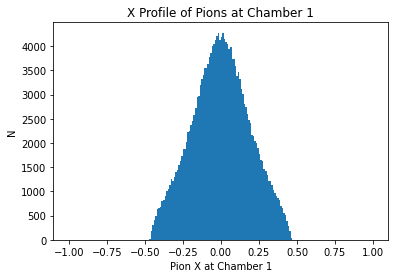

In [ ]:
plt.hist(x_chamber1, bins = 200, range = (-1,1))
plt.xlabel('Pion X at Chamber 1')
plt.ylabel('N')
plt.title('X Profile of Pions at Chamber 1')
plt.show()

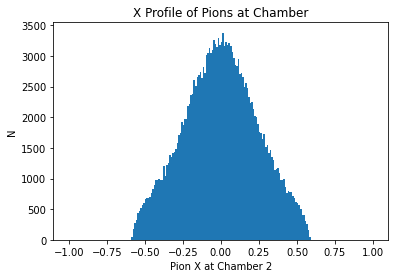

In [ ]:
plt.hist(x_chamber2, bins = 200, range = (-1,1))
plt.xlabel('Pion X at Chamber 2')
plt.ylabel('N')
plt.title('X Profile of Pions at Chamber')
plt.show()

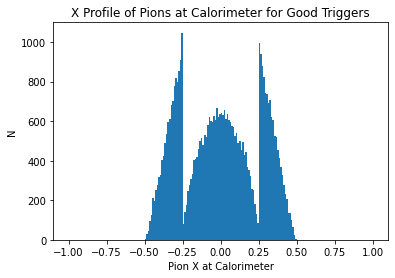

In [ ]:
plt.hist(x_trig, bins = 200, range = (-1, 1))
plt.title('X Profile of Pions at Calorimeter for Good Triggers')
plt.xlabel('Pion X at Calorimeter')
plt.ylabel('N')
plt.show()

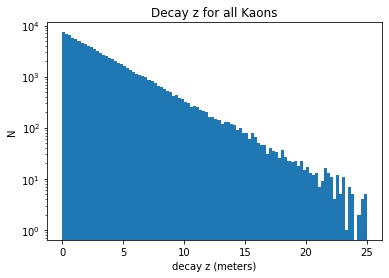

In [ ]:
plt.hist(initZ, bins = 100, range = (0,25))
plt.yscale('log')
plt.title('Decay z for all Kaons')
plt.xlabel('decay z (meters)')
plt.ylabel('N')
plt.show()

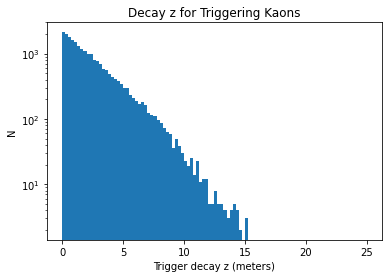

In [ ]:
plt.hist(z_trig, bins = 100, range = (0,25))
plt.yscale('log')
plt.title('Decay z for Triggering Kaons')
plt.xlabel('Trigger decay z (meters)')
plt.ylabel('N')
plt.show()

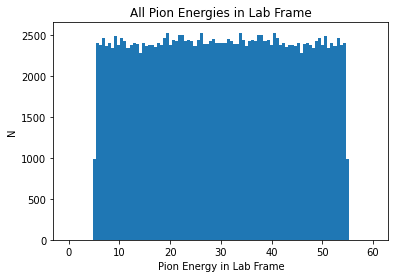

In [ ]:
plt.hist(energies, bins = 100, range = (0,60))
plt.xlabel('Pion Energy in Lab Frame')
plt.ylabel('N')
plt.title('All Pion Energies in Lab Frame')
plt.show()

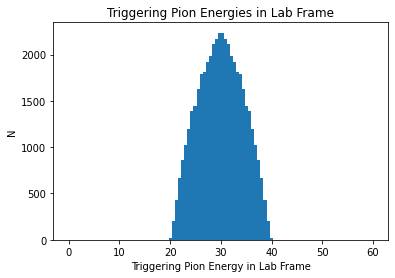

In [ ]:
plt.hist(energies_good, bins = 100, range = (0,60))
plt.xlabel('Triggering Pion Energy in Lab Frame')
plt.ylabel('N')
plt.title('Triggering Pion Energies in Lab Frame')
plt.show()

### b. Why events fail to satisfy the trigger

Please determine the fraction of kaon decays that fall into the following categories:  

1. the decay satisfies the experiment trigger: both pions pass through the active areas of the two tracking chambers and strike the active region of the calorimeter;
2. one pion goes (or both pions go) down the hole in the calorimeter;
3. one pion goes (or both pions go) wide of the calorimeter;

You should find that about 77% of the decaying kaons put at least one pion down the hole. Next unit you’ll work on maximizing the fraction of kaon decays that actually satisfy the experiment’s trigger. Here are my results:
```
number of decays: 100000
number of triggers: 22804
number of events with pion(s) in hole: 77196
number of events with pion(s) wide: 0
target-to-first-tracker distance: 38
```
And that’s it!

#### Answer:

In [ ]:
decays = 100000
triggers = 0
inHole = 0
wide = 0
targetToTracker1 = 38

for i in range(100000):
  vertex, pmu_plus, pmu_minus = KDG.getdecay()
  x1_p, y1_p, x2_p, y2_p, x3_p, y3_p = findPosition(vertex[2], pmu_plus[1], pmu_plus[2], pmu_plus[3])
  x1_m, y1_m, x2_m, y2_m, x3_m, y3_m = findPosition(vertex[2], pmu_minus[1], pmu_minus[2], pmu_minus[3])

  if (-0.6 < x1_p < 0.6 and -0.6 < y1_p < 0.6):
    if (-0.7 < x2_p < 0.7 and -0.7 < y2_p < 0.7):
      if (-0.75 < x3_p < 0.75 and -0.75 < y3_p < 0.75):
        if (-0.25 < x3_p < 0.25 and -0.25 < y3_p < 0.25):
          inHole += 1
        else:
          if (-0.6 < x1_m < 0.6 and -0.6 < y1_m < 0.6):
            if (-0.7 < x2_m < 0.7 and -0.7 < y2_m < 0.7):
              if (-0.75 < x3_m < 0.75 and -0.75 < y3_m < 0.75):
                if (-0.25 < x3_m < 0.25 and -0.25 < y3_m < 0.25):
                  inHole += 1
                else:
                  triggers += 1
              else:
                wide += 1

print('Number of decays:', decays)
print('Triggers:', triggers)
print('Events with Pion(s) in Hole:', inHole)
print('Events with pion(s) wide:', wide)
print('Target to first tracker distance:', targetToTracker1)

Number of decays: 100000
Triggers: 22772
Events with Pion(s) in Hole: 77228
Events with pion(s) wide: 0
Target to first tracker distance: 38


## Exercise 2 - Geometrical acceptance

* **List of collaborators:** None

* **References you used in developing your code:** None

### Background

Previously in class you determined an approximate value for $\pi$ by dropping random x, y points into a square whose sides were of unit length, then determining the fraction of points that were also contained inside the perimeter of an inscribed circle. You were, in effect, measuring the "geometrical acceptance" of the circle when exposed to a random "beam" of points. There were only two numbers you needed to describe uniquely each "event" (the placing of a point inside the square): the point's x and y coordinates. And the boundary in that x, y parameter space is easy to imagine: it's just a circle of unit diameter.  

The geometrical acceptance of a particle physics experiment can be characterized in similar fashion as a region (or regions) inside a parameter space from which we will always accept events. In our case we can completely characterize an event by specifying the z position of the decaying kaon and the two (spherical coordinate) angles needed to describe the direction of the positive pion. Everything else—the pion energies in the lab frame, for example, or the momentum of the other pion, or where in the plane of the calorimeter the pions land—can be derived from these. In a more realistic model we would need to specify the kaon’s energy and vector momentum (since it is not possible to create a monochromatic kaon beam), the x, y, z coordinates of its decay point, the pion directions in the kaon rest frame, and so on.  

You should have found in the homework due this unit that our simple experiment failed to accept most decaying kaons because one (or both) went down the hole in the calorimeter. In our simple model it is only the calorimeter that measures the energies of pions, so we are unable to determine whether or not the signals in the tracking chambers actually came from pions or something else. (Neutral kaons can decay into final states that include neutrinos, electrons, and muons: the di-pion final state is not the only possibility.)    

You probably also noticed that the pions were concentrated near the center of the tracking chambers and calorimeter. Even though the half-width of the calorimeter was 0.75 meters, almost no pions landed more than a half-meter away from its median plane. It should be obvious that we can move the kaon-producing target upstream to good effect. That will make the “solid angle” subtended by the hole smaller, and fewer pions will find it. Of course, if we move the target too far upstream we will lose events from pions going wide of the calorimeter.


### a. Plotting the occupied region of phase space

I included above a schematic representation of events populating the $\theta^\prime -\phi^\prime-z$ phase space available to decaying kaons. (The angles describe the positive pion’s trajectory.) My figure used the angles in the kaon rest frame, but I could have just as easily filled the plot with the lab-frame values instead.

That is what I would like you to do: generate decays with a few different target positions (build your program from the first unit 8 homework problem’s code) and make 3-d plots of the **lab frame** $\theta^\prime -\phi^\prime-z$ phase space, using small markers for the points corresponding to the "coordinates" in the phase space of each event. For each target position put into your plot the points for all events (as red dots, say) and then the points for all decays that trigger the apparatus (as black dots, perhaps). You will want to plot the triggering decays after plotting the “all decays” phase space points.  

The decay generator provides the lab-frame four momentum for each pion. You will need to calculate the $\theta-\phi$ angles from this. Keep in mind that $\phi$ ranges from $-\pi$ to $+\pi$, so you’ll probably need to use an arctan routine that takes two arguments.

To save time, let me remind you how to make 3-d plots. Let’s say you’ve generated 50,000 decays and stored the lab-frame phase space coordinate values in arrays this way:
```python
# phase space coordinates in LAB: pi+ theta, phi and kaon decay z, all decays.
phase_space_theta_mrad = np.array([np.nan] * number_of_decays_to_generate)
phase_space_phi = np.array([np.nan] * number_of_decays_to_generate)
phase_space_z = np.array([np.nan] * number_of_decays_to_generate)
event_satisfied_trigger = np.array([False] * number_of_decays_to_generate)

# ...
# fill the arrays of pi+ theta, phi, and z for each decay in a loop here
# ...

# now store pi+ theta, phi and kaon decay z for events that satisfied the
# trigger: define arrays then copy what you want into the arrays.
phase_space_theta_triggers_mrad = np.array([np.nan] * number_of_triggers)
phase_space_phi_triggers = np.array([np.nan] * number_of_triggers)
phase_space_z_triggers = np.array([np.nan] * number_of_triggers)

# ...
# fill the arrays
# ...


# now create a (blank) figure and get/set its axes.
fig = plt.figure()
ax = fig.gca(projection='3d')
# set the x, y, and z axis limits of the plot axes
ax.set_xlim(0., 15.)
ax.set_ylim(-3.5, 3.5)
ax.set_zlim(0, 20)
# label the axes and give the plot a title
ax.set_xlabel("theta")
ax.set_ylabel("phi")
ax.set_zlabel("z")
ax.set_title("Kaon decay phase space: all decays-- Your Name")
# now make the plot, using small red markers for all decays:
ax.plot(phase_space_theta, phase_space_phi, phase_space_z, 'ro', markersize = 1)

# now add into the plot small black markers for triggering events.
ax.plot(phase_space_theta_triggers_mrad, phase_space_phi_triggers, \
phase_space_z_triggers, 'ko', markersize = 1)
plt.show()
```

Try generating plots for these target-to-first-chamber distances, and take note of the number of triggers. My plots follow the table with my results. Rotate your plots around, taking note of the structure they exhibit. Why do they look this way? (A hint: the decay angles are azimuthally [$\phi$] symmetric, but the apparatus is not: it has four corners!)  

|target-to-tracker 1 distance (meters) |triggered events (out of 50,000)|
|--------------------------------------|--------------------------------|
|28 | 2,318|
|38 | 11,370|
|58 | 25,886|
|78 | 16,646|


<!--![phase_space_28.png](attachment:phase_space_28.png)![phase_space_38.png](attachment:phase_space_38.png)![phase_space_58.png](attachment:phase_space_58.png)![phase_space_78.png](attachment:phase_space_78.png)-->

<tr>
    <td style="text-align:center">28 meters:</td>
    <td style="text-align:center">38 meters:</td>
</tr>
<tr>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans2_11.png" width="469px" /></td>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans2_12.png" width="469px" /></td>
</tr>
<tr>
    <td style="text-align:center">58 meters:</td>
    <td style="text-align:center">78 meters:</td>
</tr>
<tr>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans2_21.png" width="469px" /></td>
    <td><img src="https://courses.physics.illinois.edu/phys246/fa2020/code/images/PP/ans2_22.png" width="469px" /></td>
</tr>


#### Answer

z =  28


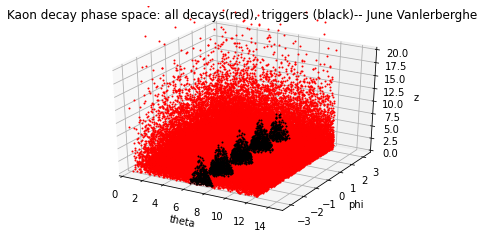

z =  38


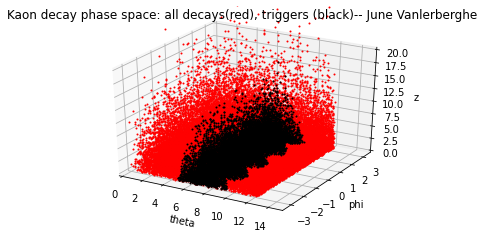

z =  58


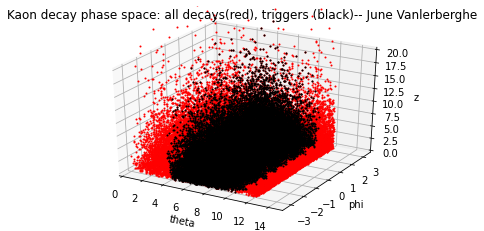

z =  78


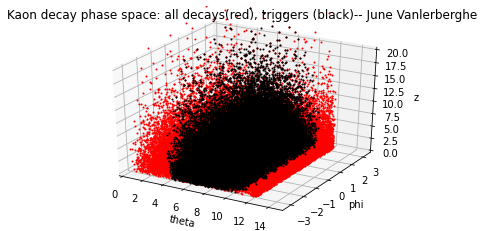

In [ ]:

number_of_decays_to_generate = 50000

phase_space_theta_mrad = np.array([np.nan] * number_of_decays_to_generate)
phase_space_phi = np.array([np.nan] * number_of_decays_to_generate)
phase_space_z = np.array([np.nan] * number_of_decays_to_generate)
event_satisfied_trigger = np.array([False] * number_of_decays_to_generate)

phase_space_theta_triggers_mrad = []
phase_space_phi_triggers = []
phase_space_z_triggers = []

vals = [28, 38, 58, 78]
for x in vals:
  t1_z = x
  t2_z = t1_z + 10
  calor_z = t1_z + 15
  for i in range(number_of_decays_to_generate):
    vertex, pmu_plus, pmu_minus = KDG.getdecay()
    z = vertex[2]
    theta = np.arctan2(np.sqrt(pmu_plus[1]**2 + pmu_plus[2]**2), pmu_plus[3])*(10**3)
    phi = np.arctan2(pmu_plus[2], pmu_plus[1])

    phase_space_theta_mrad[i] = theta
    phase_space_phi[i] = phi
    phase_space_z[i] = z

    t1_plus = (t1_z-z)/pmu_plus[3]
    t1_minus = (t1_z-z)/pmu_minus[3]
    x1_p = t1_plus*pmu_plus[1]
    x1_m = t1_minus*pmu_minus[1]
    y1_p = t1_plus*pmu_plus[2]
    y1_m = t1_minus*pmu_minus[2]

    t2_plus = (t2_z-z)/pmu_plus[3]
    t2_minus = (t2_z-z)/pmu_minus[3]
    x2_p = t2_plus*pmu_plus[1]
    x2_m = t2_minus*pmu_minus[1]
    y2_p = t2_plus*pmu_plus[2]
    y2_m = t2_minus*pmu_minus[2]

    t3_plus = (calor_z-z)/pmu_plus[3]
    t3_minus = (calor_z-z)/pmu_minus[3]
    x3_p = t3_plus*pmu_plus[1]
    x3_m = t3_minus*pmu_minus[1]
    y3_p = t3_plus*pmu_plus[2]
    y3_m = t3_minus*pmu_minus[2]

    if (-0.6 < x1_p < 0.6 and -0.6 < y1_p < 0.6):
      if (-0.7 < x2_p < 0.7 and -0.7 < y2_p < 0.7):
        if (-0.75 < x3_p < 0.75 and -0.75 < y3_p < 0.75):
          if (-0.25 < x3_p < 0.25 and -0.25 < y3_p < 0.25):
            continue
          else:
            if (-0.6 < x1_m < 0.6 and -0.6 < y1_m < 0.6):
              if (-0.7 < x2_m < 0.7 and -0.7 < y2_m < 0.7):
                if (-0.75 < x3_m < 0.75 and -0.75 < y3_m < 0.75):
                  if (-0.25 < x3_m < 0.25 and -0.25 < y3_m < 0.25):
                    continue
                  else:
                    event_satisfied_trigger[i] = True
                    phase_space_theta_triggers_mrad.append(theta)
                    phase_space_phi_triggers.append(phi)
                    phase_space_z_triggers.append(z)


  fig = plt.figure()
  ax = fig.gca(projection='3d')

  ax.set_xlim(0., 15.)
  ax.set_ylim(-3.5, 3.5)
  ax.set_zlim(0, 20)

  ax.set_xlabel("theta")
  ax.set_ylabel("phi")
  ax.set_zlabel("z")
  ax.set_title("Kaon decay phase space: all decays(red), triggers (black)-- June Vanlerberghe")
  print("z = ", x)
  ax.plot(phase_space_theta_mrad, phase_space_phi, phase_space_z, 'ro', markersize = 1)
  ax.plot(phase_space_theta_triggers_mrad, phase_space_phi_triggers, \
  phase_space_z_triggers, 'ko', markersize = 1)
  plt.show()

## Exercise 3 - Finding Optimal Target Position

* **List of collaborators:** None

* **References you used in developing your code:** None

🦉Find the target-to-first-tracker distance that maximizes your experiment’s geometrical acceptance. You ought to be able to do something clever with the program that you just wrote: for example, try wrapping a loop around part of your program to hunt for the best target position.  

Try running about 10,000 decaying kaons per trial target position, with z scans spaced by a meter or two. Once you get close to the optimal z position, do a more fine-grained scan at greater statistical precision. Try for an ultimate accuracy of about 50 centimeters.  

This is one of the most common uses for a Monte Carlo simulation, helping physicists optimize the configuration of an experiment.  

I find that the acceptance peaks at about 52% for a target-to-tracker1 separation of  about 59.6 meters. If you’re within a meter of my result, you’ve probably found something that is statistically indistinguishable from my result, so declare victory.  

#### Answer

In [ ]:
number_of_decays_to_generate = 10000
best_distance = 0
highest_percent_accepted = 0

for x in range(80):
  t1_z = x
  t2_z = t1_z + 10
  calor_z = t1_z + 15
  trigger_count = 0
  for i in range(number_of_decays_to_generate):
    vertex, pmu_plus, pmu_minus = KDG.getdecay()
    z = vertex[2]

    t1_plus = (t1_z-z)/pmu_plus[3]
    t1_minus = (t1_z-z)/pmu_minus[3]
    x1_p = t1_plus*pmu_plus[1]
    x1_m = t1_minus*pmu_minus[1]
    y1_p = t1_plus*pmu_plus[2]
    y1_m = t1_minus*pmu_minus[2]

    t2_plus = (t2_z-z)/pmu_plus[3]
    t2_minus = (t2_z-z)/pmu_minus[3]
    x2_p = t2_plus*pmu_plus[1]
    x2_m = t2_minus*pmu_minus[1]
    y2_p = t2_plus*pmu_plus[2]
    y2_m = t2_minus*pmu_minus[2]

    t3_plus = (calor_z-z)/pmu_plus[3]
    t3_minus = (calor_z-z)/pmu_minus[3]
    x3_p = t3_plus*pmu_plus[1]
    x3_m = t3_minus*pmu_minus[1]
    y3_p = t3_plus*pmu_plus[2]
    y3_m = t3_minus*pmu_minus[2]

    if (-0.6 < x1_p < 0.6 and -0.6 < y1_p < 0.6):
      if (-0.7 < x2_p < 0.7 and -0.7 < y2_p < 0.7):
        if (-0.75 < x3_p < 0.75 and -0.75 < y3_p < 0.75):
          if (-0.25 < x3_p < 0.25 and -0.25 < y3_p < 0.25):
            continue
          else:
            if (-0.6 < x1_m < 0.6 and -0.6 < y1_m < 0.6):
              if (-0.7 < x2_m < 0.7 and -0.7 < y2_m < 0.7):
                if (-0.75 < x3_m < 0.75 and -0.75 < y3_m < 0.75):
                  if (-0.25 < x3_m < 0.25 and -0.25 < y3_m < 0.25):
                    continue
                  else:
                    trigger_count += 1

  percent_accepted = trigger_count/number_of_decays_to_generate
  if (percent_accepted > highest_percent_accepted):
    best_distance = x
    highest_percent_accepted = percent_accepted

for x in range((best_distance - 1)*10, (best_distance + 1)*10):
    t1_z = x/10
    t2_z = t1_z + 10
    calor_z = t1_z + 15
    trigger_count = 0
    for i in range(number_of_decays_to_generate):
      vertex, pmu_plus, pmu_minus = KDG.getdecay()
      z = vertex[2]

      t1_plus = (t1_z-z)/pmu_plus[3]
      t1_minus = (t1_z-z)/pmu_minus[3]
      x1_p = t1_plus*pmu_plus[1]
      x1_m = t1_minus*pmu_minus[1]
      y1_p = t1_plus*pmu_plus[2]
      y1_m = t1_minus*pmu_minus[2]

      t2_plus = (t2_z-z)/pmu_plus[3]
      t2_minus = (t2_z-z)/pmu_minus[3]
      x2_p = t2_plus*pmu_plus[1]
      x2_m = t2_minus*pmu_minus[1]
      y2_p = t2_plus*pmu_plus[2]
      y2_m = t2_minus*pmu_minus[2]

      t3_plus = (calor_z-z)/pmu_plus[3]
      t3_minus = (calor_z-z)/pmu_minus[3]
      x3_p = t3_plus*pmu_plus[1]
      x3_m = t3_minus*pmu_minus[1]
      y3_p = t3_plus*pmu_plus[2]
      y3_m = t3_minus*pmu_minus[2]

      if (-0.6 < x1_p < 0.6 and -0.6 < y1_p < 0.6):
        if (-0.7 < x2_p < 0.7 and -0.7 < y2_p < 0.7):
          if (-0.75 < x3_p < 0.75 and -0.75 < y3_p < 0.75):
            if (-0.25 < x3_p < 0.25 and -0.25 < y3_p < 0.25):
              continue
            else:
              if (-0.6 < x1_m < 0.6 and -0.6 < y1_m < 0.6):
                if (-0.7 < x2_m < 0.7 and -0.7 < y2_m < 0.7):
                  if (-0.75 < x3_m < 0.75 and -0.75 < y3_m < 0.75):
                    if (-0.25 < x3_m < 0.25 and -0.25 < y3_m < 0.25):
                      continue
                    else:
                      trigger_count += 1

    percent_accepted = trigger_count/number_of_decays_to_generate
    if (percent_accepted > highest_percent_accepted):
      best_distance = x/10
      highest_percent_accepted = percent_accepted

print('The best distance is:', best_distance, 'with accuracy of:', highest_percent_accepted)

The best distance is: 59.5 with accuracy of: 0.5242


# Exercise 4 - Better Searching (EC)

### a. Better Searching

*Extra credit (5 points)*  
Implement binary search to find the peak acceptance. Don't forget your acceptance ratios have error bars!  

#### Solution:

In [ ]:
def findAccuracy(z):
  number_of_decays_to_generate = 10000
  t1_z = z
  t2_z = t1_z + 10
  calor_z = t1_z + 15
  trigger_count = 0
  for i in range(number_of_decays_to_generate):
    vertex, pmu_plus, pmu_minus = KDG.getdecay()
    z = vertex[2]

    t1_plus = (t1_z-z)/pmu_plus[3]
    t1_minus = (t1_z-z)/pmu_minus[3]
    x1_p = t1_plus*pmu_plus[1]
    x1_m = t1_minus*pmu_minus[1]
    y1_p = t1_plus*pmu_plus[2]
    y1_m = t1_minus*pmu_minus[2]

    t2_plus = (t2_z-z)/pmu_plus[3]
    t2_minus = (t2_z-z)/pmu_minus[3]
    x2_p = t2_plus*pmu_plus[1]
    x2_m = t2_minus*pmu_minus[1]
    y2_p = t2_plus*pmu_plus[2]
    y2_m = t2_minus*pmu_minus[2]

    t3_plus = (calor_z-z)/pmu_plus[3]
    t3_minus = (calor_z-z)/pmu_minus[3]
    x3_p = t3_plus*pmu_plus[1]
    x3_m = t3_minus*pmu_minus[1]
    y3_p = t3_plus*pmu_plus[2]
    y3_m = t3_minus*pmu_minus[2]

    if (-0.6 < x1_p < 0.6 and -0.6 < y1_p < 0.6):
      if (-0.7 < x2_p < 0.7 and -0.7 < y2_p < 0.7):
        if (-0.75 < x3_p < 0.75 and -0.75 < y3_p < 0.75):
          if (-0.25 < x3_p < 0.25 and -0.25 < y3_p < 0.25):
            continue
          else:
            if (-0.6 < x1_m < 0.6 and -0.6 < y1_m < 0.6):
              if (-0.7 < x2_m < 0.7 and -0.7 < y2_m < 0.7):
                if (-0.75 < x3_m < 0.75 and -0.75 < y3_m < 0.75):
                  if (-0.25 < x3_m < 0.25 and -0.25 < y3_m < 0.25):
                    continue
                  else:
                    trigger_count += 1


  return trigger_count/number_of_decays_to_generate


In [ ]:
def BinarySearch(z_low, z_high):
  mid = (z_low + z_high)/2
  mid_acc = findAccuracy(mid)
  low_acc = findAccuracy(z_low)
  high_acc = findAccuracy(z_high)
  if (mid_acc > low_acc and mid_acc > high_acc):
    return mid

  if (mid_acc >= low_acc):
    return BinarySearch(mid, z_high)
  if (mid_acc <= low_acc):
    return BinarySearch(z_low, mid)

print(BinarySearch(0,80))

60.0


### b. Alternative Options
_Extra Credit (5 points)_  
**Q:** Why does golden ratio search not work here? Explain

**A:**

© Copyright 2020  
Originally developed by George Gollin for 298OWL  
Ported to Jupyter by BKC & RL (2019)

---

<span id=“fn1”><sup>1</sup> J. H. Christenson, *et al*., Phys. Rev. Lett. *43*, 1209 (1979) and J. H. Christenson, *et al*., Phys. Rev. Lett. *43*, 1212 (1979).</span>  

<span id=“fn2”><sup>2</sup>It was the 773<sup>rd</sup> proposal received by Fermilab’s Proposal Advisory Committee and was given the catchy name "E773." We did the experiment, achieved the proposed sensitivity, and concluded that Christenson's anomaly was not supported by our data, alas.</span>
